# EDA & Modeling Workbook (Project V1)

- [Simple EDA](#simple-eda)
- [Baseline Model](#baseline-model)
---

In [40]:
%config InlineBackend.figure_formats = ['retina']

import sys
import pandas as pd
import matplotlib.pyplot as plt
import spotipy
from spotipy import oauth2, util
import seaborn as sns
import statsmodels.api as sm

from sklearn.linear_model import LinearRegression, Lasso
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures, StandardScaler

# add parent folder to path to be able to import utility functions
sys.path.append('..')
from utilities.data_acquisition_utilities import get_spotify_track_audio_features_for_album, \
                                                    replace_track_features_with_correct_album

Load data.

In [10]:
dataset_v1 = pd.read_pickle('../data/dataset_v1.pkl')

<h3><a id=simple-eda>Simple EDA</a></h3>

Visualize distributions of each feature and potential linearities between each feature and the target, as well as amongst the features.

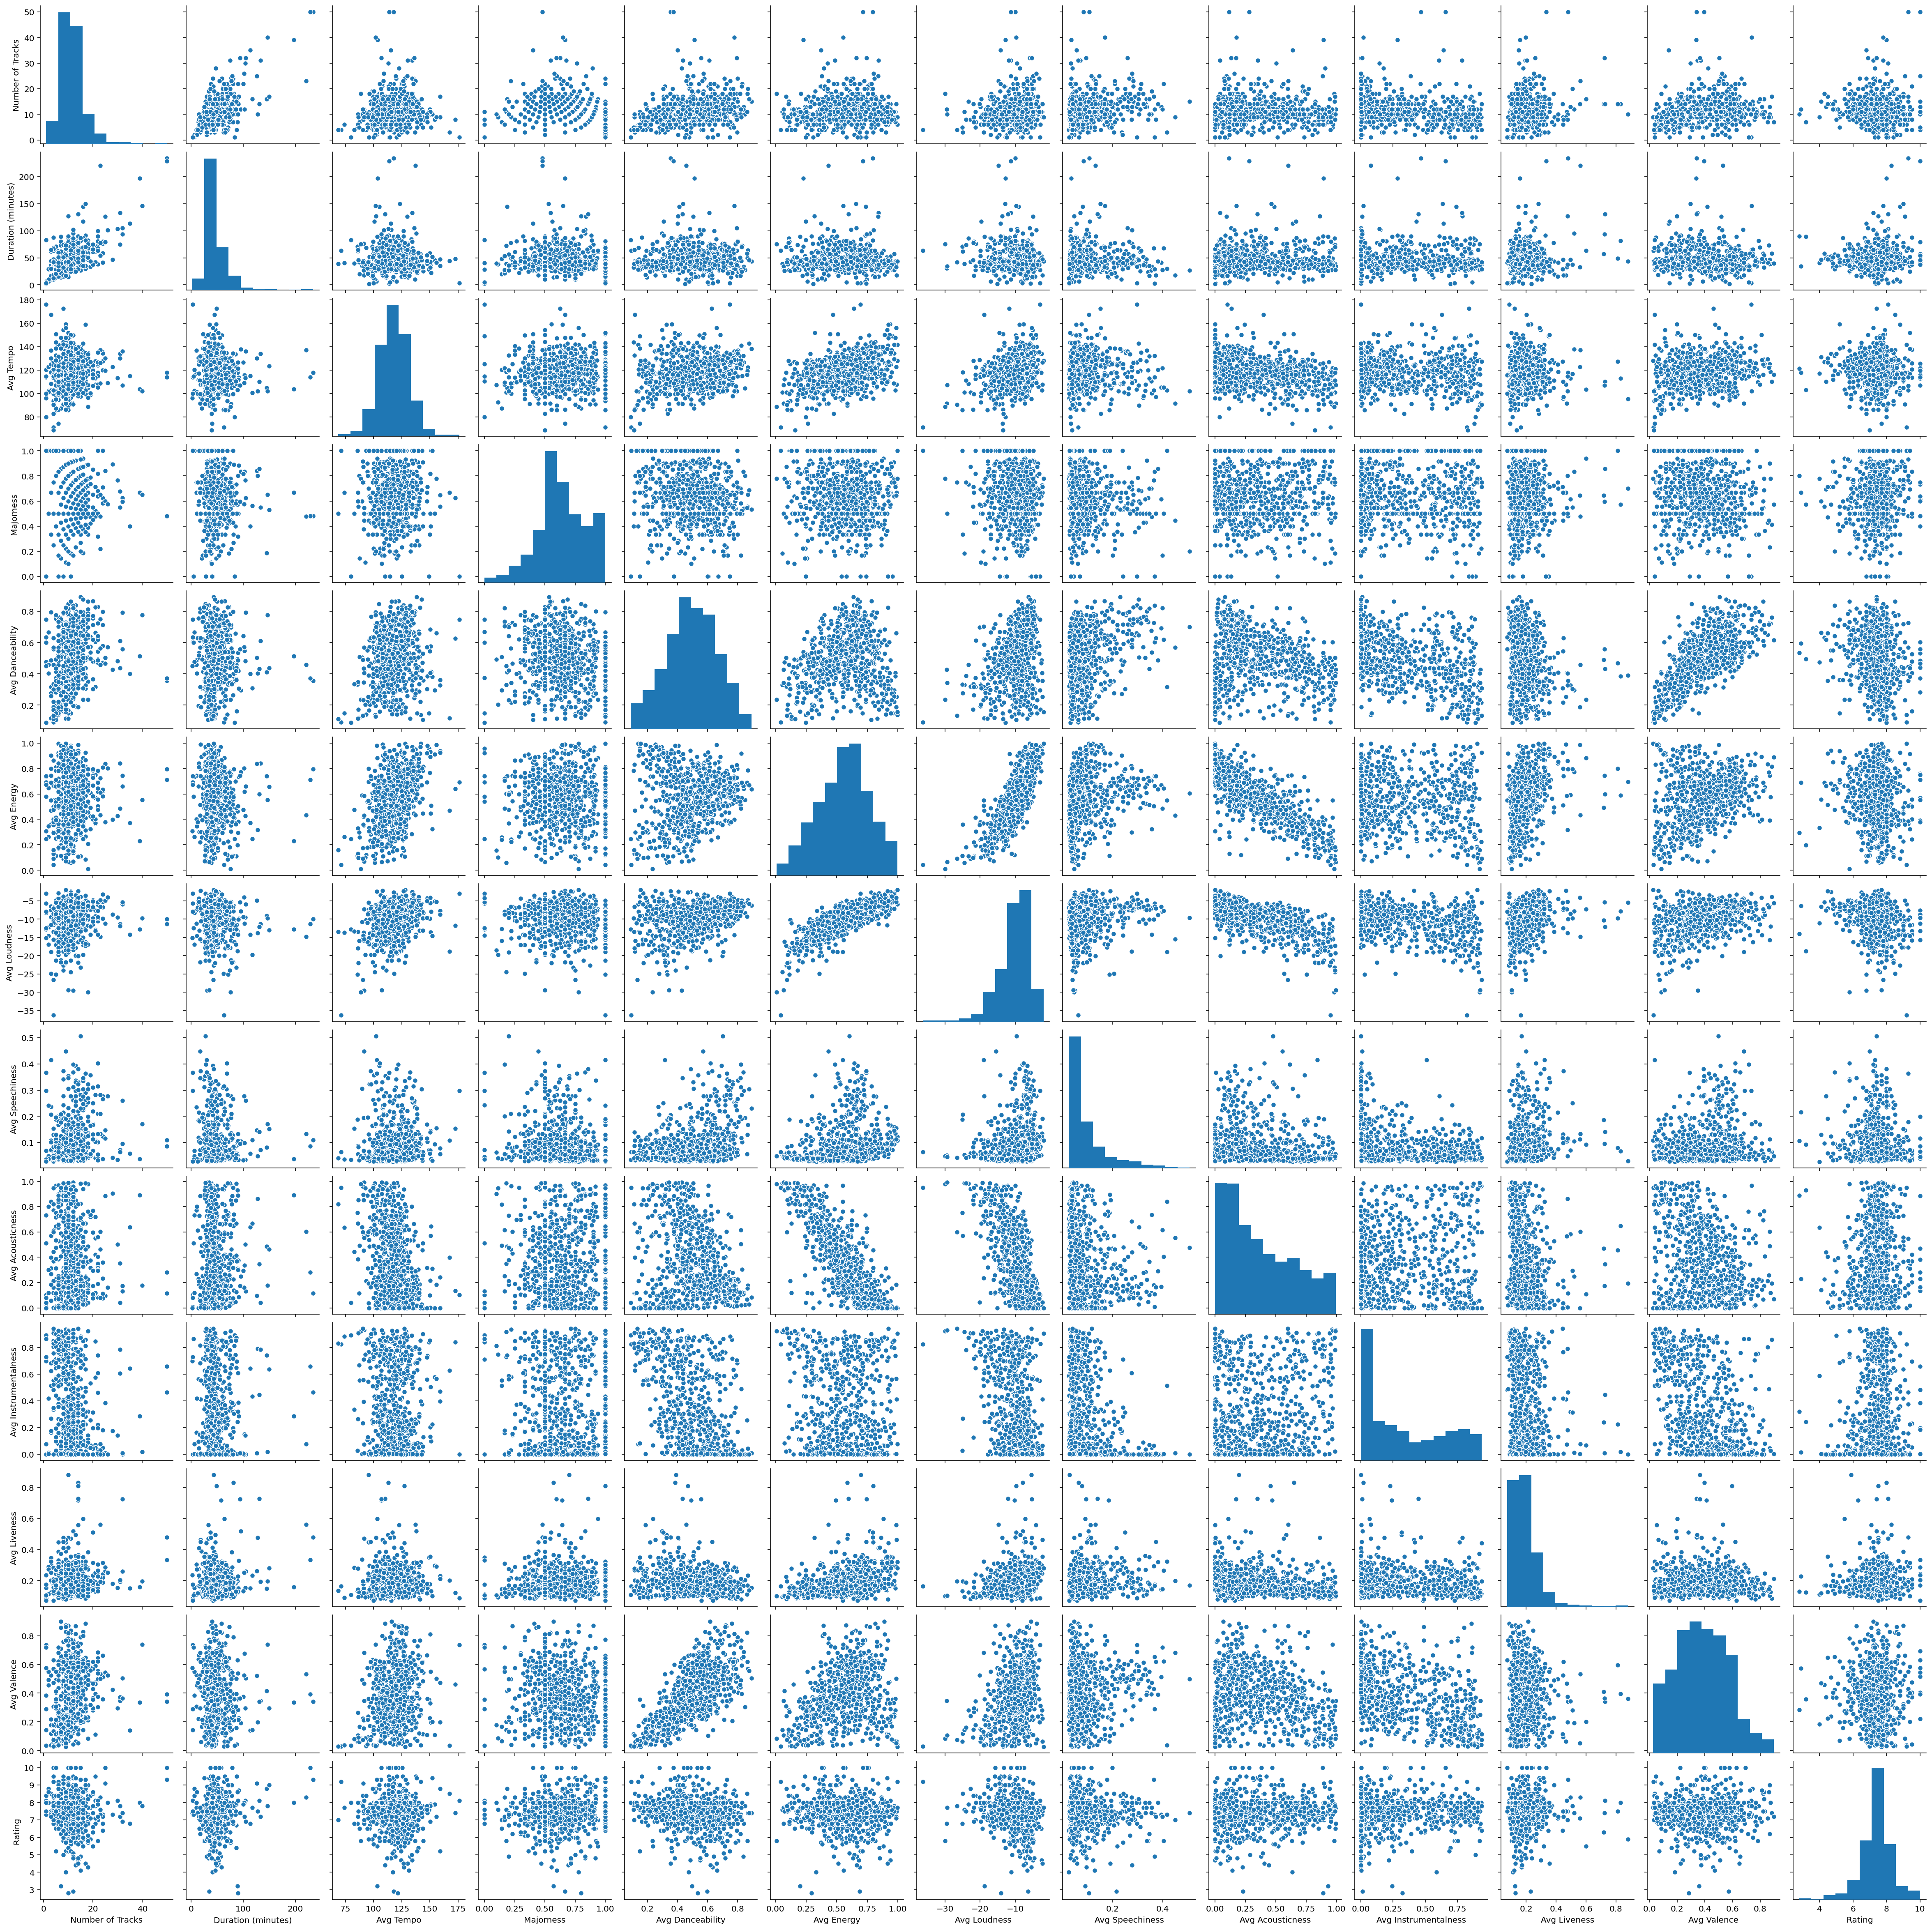

In [11]:
sns.pairplot(dataset_v1)

Genre is categorical and not included in the pairplot, but I still want to see if it is related to Rating.

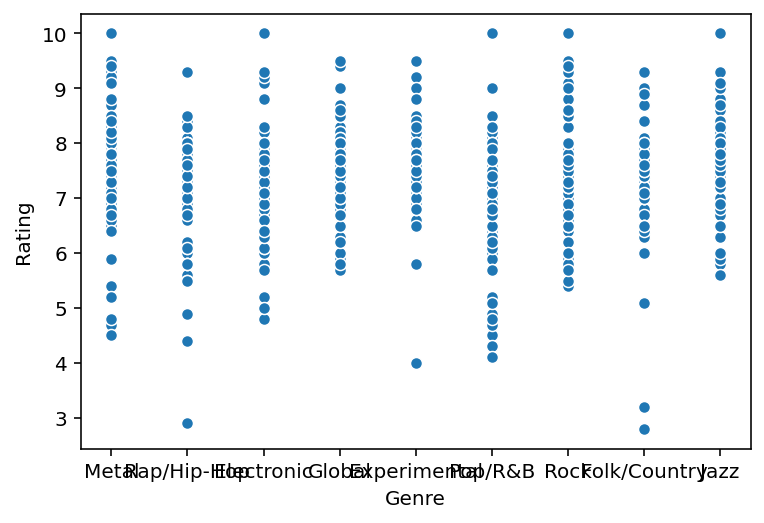

In [21]:
sns.scatterplot(x=dataset_v1['Genre'], y=dataset_v1['Rating'])

#### Initial Takeaways

##### What do the plots tell me about the distribution of the target?
Approximately normal with a very slight skew towards higher scores. That could indicate a good target.

##### Are there any colinearities in the features?

The following may be problematic colinearities between features:
* Danceability & Valence
* Energy & Loudness
* Energy & Acousticness (negative)
* Loudness & Acousticness (negative)

##### What about relationships between each feature and target?

There don't appear to be any obvious linear relationships between features and the target. This could be a huge problem for modeling Pitchfork album ratings. For now I'll keep doing EDA and build a baseline model, but I might hit 
a dead end.

<h3><a id=baseline-model>Baseline Model</a></h3>

`statsmodels` gives us an initial look at p-values with this feature set.

In [12]:
X = dataset_v1[['Number of Tracks', 'Duration (minutes)', 'Avg Tempo', 'Avg Danceability', 'Avg Energy', 'Avg Loudness', 
                 'Avg Acousticness', 'Avg Instrumentalness', 'Avg Liveness',  'Avg Valence']]
y = dataset_v1['Rating']

In [13]:
baseline_model = sm.OLS(y,X)
baseline_fit = baseline_model.fit()
baseline_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                 Rating   R-squared (uncentered):                   0.981
Model:                            OLS   Adj. R-squared (uncentered):              0.981
Method:                 Least Squares   F-statistic:                              3951.
Date:                Mon, 13 Jul 2020   Prob (F-statistic):                        0.00
Time:                        10:58:08   Log-Likelihood:                         -1098.0
No. Observations:                 763   AIC:                                      2216.
Df Residuals:                     753   BIC:                                      2262.
Df Model:                          10                                                  
Covariance Type:            nonrobust                                                  
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Number of Tracks         0.0013      0.011      0.121      0.903      -0.019       0.022
Duration (minutes)       0.0051      0.002      2.195      0.028       0.001       0.010
Avg Tempo                0.0267      0.003     10.573      0.000       0.022       0.032
Avg Danceability        -0.2848      0.341     -0.834      0.404      -0.955       0.385
Avg Energy               2.7137      0.373      7.283      0.000       1.982       3.445
Avg Loudness            -0.1632      0.014    -11.773      0.000      -0.190      -0.136
Avg Acousticness         0.9553      0.206      4.632      0.000       0.550       1.360
Avg Instrumentalness    -0.0667      0.161     -0.415      0.678      -0.382       0.249
Avg Liveness             1.4245      0.465      3.063      0.002       0.512       2.337
Avg Valence              0.8082      0.301      2.689      0.007       0.218       1.398
==============================================================================
Omnibus:                       76.083   Durbin-Watson:                   1.929
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              154.507
Skew:                          -0.604   Prob(JB):                     2.81e-34
Kurtosis:                       4.844   Cond. No.                     1.82e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.82e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Build the same model with `sklearn` and then score an initial train/test.

In [29]:
def split_and_validate(X, y):
    '''
    For a set of features and target X, y, perform a 80/20 train/val split, 
    fit and validate a linear regression model, and report results
    '''
    
    # perform train/val split
    X_train, X_val, y_train, y_val = \
        train_test_split(X, y, test_size=0.2, random_state=42)
    
    # fit linear regression to training data
    lr_model = LinearRegression()
    lr_model.fit(X_train, y_train)
    
    # score fit model on validation data
    val_score = lr_model.score(X_val, y_val)
    
    # report results
    print('\nValidation R^2 score was:', val_score)
    print('Feature coefficient results: \n')
    for feature, coef in zip(X.columns, lr_model.coef_):
        print(feature, ':', f'{coef:.2f}') 

In [19]:
split_and_validate(X, y)


Validation R^2 score was: 0.09087221042205362
Feature coefficient results: 

Number of Tracks : -0.01
Duration (minutes) : 0.00
Avg Tempo : 0.00
Avg Danceability : -2.03
Avg Energy : -0.13
Avg Loudness : -0.04
Avg Acousticness : -0.19
Avg Instrumentalness : -0.12
Avg Liveness : -0.13
Avg Valence : 1.40


The initial R2 score of `0.09087` is not promising. As a final attempt, I'll create some polynomial terms.

In [23]:
poly = PolynomialFeatures(2)
X_with_poly = poly.fit_transform(X)

Test out the result of using a LASSO model.

In [3]:
def split_and_validate_lasso(X, y, alpha):
    '''
    For a set of features and target X, y, perform a 80/20 train/val split, 
    fit and validate a LASSO model, and report results
    '''
    
    # perform train/val split
    X_train, X_val, y_train, y_val = \
        train_test_split(X, y, test_size=0.2, random_state=42)
    
    # standard scale data 
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    
    # fit LASSO to training data
    clf = Lasso(alpha)
    clf.fit(X_train_scaled, y_train)
    
    # score fit model on validation data
    val_score = clf.score(X_val_scaled, y_val)
    # score train data
    train_score = clf.score(X_train_scaled, y_train)

    
    # report results
    print('\nTrain R2 score was', train_score)
    print('\nValidation R^2 score was:', val_score)

In [4]:
for alpha in [0.1, 1, 10, 100, 1000]:
    print(f"alpha: {alpha}")
    split_and_validate_lasso(X_with_poly, y, alpha)

alpha: 0.1


NameError: name 'X_with_poly' is not defined

Still not great, but an alpha of 0.1 seems to be the best order of magnitude. Iterating around 0.1 now...

In [48]:
for alpha in [0.08, 0.09, 0.1, .11, 0.12, 0.13, 0.2]:
    print(f"alpha: {alpha}")
    split_and_validate_lasso(X_with_poly, y, alpha)

alpha: 0.08

Validation R^2 score was: 0.07882651678187869
alpha: 0.09

Validation R^2 score was: 0.06973142394663012
alpha: 0.1

Validation R^2 score was: 0.059518749404966265
alpha: 0.11

Validation R^2 score was: 0.0488644936001027
alpha: 0.12

Validation R^2 score was: 0.038447034399958335
alpha: 0.13

Validation R^2 score was: 0.027541118577590784
alpha: 0.2

Validation R^2 score was: -1.0363470659413565e-07


<h3><a id=pivot>Decision to Pivot Project</a></h3>

After creating a baseline model, adding polynomial features and running a LASSO, and doing a gut check train/test split on the data to score the model, I'm still left with an abysmal fit. Here are my options:
- spend more time on feature engineering, using more elaborate features
- choose a different data source for features altogether to try and predict Pitchfork Album Ratings

If I was being asked by an employer or client to specifically predict Pitchfork album ratings, I would persist by continuing to find or engineer new features, and maybe even apply a completing different ML algorithm (which at this time in the Metis program I am lacking).

My suspicion is that attempting to aggregate track-level features into some kind of album metric is diluting the meaning of the features.

So, I am going to pivot the prediction target to Spotify "popularity" which measures the popularity on a scale of 0 to 100, and most importantly, **is available for each track**. Refer to `EDA & Modeling Workbook (Project V2).ipynb`.